In [1]:
from os import path
import pandas as pd
from scipy.stats import pearsonr

from gradecc.utils.filenames import data_outside
from gradecc.utils.filenames import subjects_filename
from gradecc.compute.measures import get_measures
from gradecc.plot import plot_subc, plot_cortex

## behavioural metrics

In [2]:
def make_behaviour():
    df_behaviour_ = pd.read_csv(path.join(data_outside, 'RL_behavior.csv'))
    # J's comments. try removing zeros
    # how they're distributed through time. and for subjects
    df_behaviour_ = df_behaviour_[df_behaviour_.Score > 0]
    df_behaviour_ = df_behaviour_[df_behaviour_.Subject != 'CS1']
    # or set `CS1` first scores to zero
    return df_behaviour_

df_behaviour = make_behaviour()

subjects_match = pd.read_csv(subjects_filename, delimiter='\t')
subjects_match = subjects_match[subjects_match.exclude == False]

# is `Score` the best measure? todo get path trace to try others
#  PCA on score instead of mere average agg

# maybe cluster subjects here. eg, based on average of last trials

In [3]:
# todo learn what to do with many params
def agg_metric(df, window='first', metric='Score', rename=None,
               score_window=20, block=2, agg='mean'):
    # block 1 is baseline, 2 is learning
    sub_window = True
    if window == 'first':
        sub_window = df.Trial <= score_window
    elif window == 'last':
        max_ = df[df.Block == block].Trial.max()
        sub_window = df.Trial >= max_ - score_window

    if rename is None:
        rename = metric + '_' + agg + '_' + window + str(score_window)

    return df[(df.Block == block) & sub_window] \
        .groupby('Subject')[metric].agg(agg) \
        .rename(rename)


def make_metrics(df=df_behaviour):
    metrics_ = pd.concat(
        [
            agg_metric(df, agg='median', window='first'),
            agg_metric(df, agg='median', window='last'),
            agg_metric(df, agg='mean', window='first'),
            agg_metric(df, agg='mean', window='last'),
            agg_metric(df, agg='std', window='first'),
            agg_metric(df, agg='std', window='last'),
            agg_metric(df, agg='std', window='first',
                       score_window=70, block=1, rename='Score_std_baseline'),
        ],
        axis=1, join="outer", ignore_index=False,
    )
    metrics_['Score_median_diff20'] = \
        metrics_['Score_median_last20'] - metrics_['Score_median_first20']

    metrics_['Score_mean_diff20'] = \
        metrics_['Score_mean_last20'] - metrics_['Score_mean_first20']
    return metrics_


metrics = make_metrics()

## neural features

In [4]:
def make_measures():
    # merged with subject (str)
    df_measures = get_measures()
    df_measures = df_measures.merge(subjects_match, left_on='subject', right_on='participant_id')
    df_ecc_diff = df_measures[df_measures.measure == 'eccentricity'] \
        .pivot(columns='epoch', values='value',
               index=['region', 'measure', 'dicom_dir']).reset_index()
    df_ecc_diff['b2e'] = df_ecc_diff['early'] - df_ecc_diff['baseline']
    df_ecc_diff['e2l'] = df_ecc_diff['late'] - df_ecc_diff['early']
    df_ecc_diff = pd.melt(df_ecc_diff.reset_index(),
                          id_vars=['region', 'dicom_dir', 'measure'],
                          value_vars=['baseline', 'early', 'late', 'b2e', 'e2l'],
                          var_name='epoch_', value_name='value')
    df_measures_extended_ = df_measures.rename(columns={'epoch': 'epoch_'})[df_ecc_diff.columns]
    df_measures_extended_ = pd.concat([df_measures_extended_, df_ecc_diff], axis=0)
    return df_measures_extended_


df_measures_extended = make_measures()

Reading data from /Users/qasem/PycharmProjects/gradients-rl-task/data/cache/measures.csv


In [5]:
df_metrics = df_measures_extended.merge(metrics.reset_index(), how='inner',
                                        left_on='dicom_dir', right_on='Subject')

# inference

## correlational relationships

In [6]:
def corr(data, a, b):
    return pearsonr(data[a], data[b])


def _expand_p_r(df, metric):
    return pd.DataFrame(
        df.tolist(), index=df.index,
        columns=['r_' + metric, 'p_' + metric],
    )


def make_correlations(df=df_metrics):
    df_corr_list = []
    for metric in metrics.columns:
        df_corr_ = df.groupby(['epoch_', 'measure', 'region']).apply(corr, 'value', metric)
        df_corr_list.append(_expand_p_r(df_corr_, metric))
    df_correlations = pd.concat(df_corr_list, axis=1, join="outer", ignore_index=False)
    df_correlations[df_correlations.p_Score_median_last20 < 0.05].reset_index()
    # df_correlations.to_csv(path.join(data_inside, 'behavioral_pr.csv'))
    return df_correlations


df_corr = make_correlations()

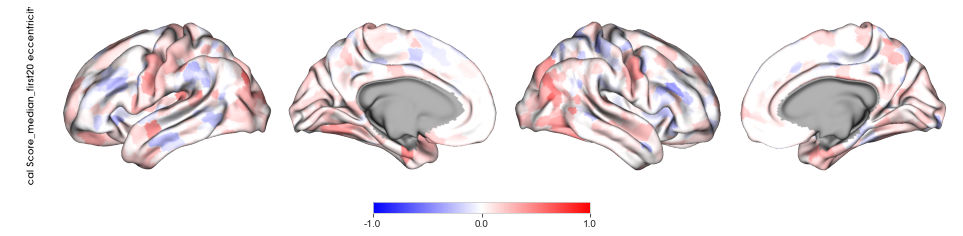

In [7]:

# todo make function to match by index


def plot_behaviour_corr(metric, df=df_corr, epochs_=None, measures=None):
    if epochs_ is None:
        epochs_ = ['baseline', 'early', 'late']
    if measures is None:
        measures = ['eccentricity']
    color_range = (-1, 1)

    for grad in measures:
        for epoch in epochs_:
            data = df.xs((epoch, grad)).reset_index()

            text = metric + ' ' + grad + ' ' + epoch.upper()

            plot_cortex(data, value=('r_' + metric),
                        # mask=('p_' + metric),
                        color_map='bwr', color_range=color_range,
                        text=('cortical ' + text),
                        save_figure=True
                        )

            plot_subc(data, value=('r_' + metric),
                      color_map='bwr', color_range=color_range,
                      text=('subcortical ' + text),
                      )


plot_behaviour_corr(metric='Score_median_first20',
                    epochs_=['e2l'], measures=['eccentricity'])

In [8]:

# for m in ['Score_median_first20', 'Score_median_last20', 'Score_median_diff20', 'Score_std_baseline']:
#     _plot_behaviour_corr(metric=m, measures=['eccentricity'],
#         epochs_=['baseline', 'early', 'late', 'b2e', 'e2l'])


In [9]:

# todo apply FDR

## cross behaviour relations

In [10]:
def make_cross_behaviour():
    cross_list = []
    for metric in ['Score_median_first20', 'Score_median_last20', 'Score_median_diff20', ]:
        df_cross_ = df_metrics[(df_metrics.measure == 'eccentricity') &
                               (df_metrics.epoch_ == 'baseline')] \
            .groupby('region').apply(corr, 'Score_std_baseline', metric)
        cross_list.append(_expand_p_r(df_cross_, metric))
    df_cross = pd.concat(cross_list, axis=1, join="outer", ignore_index=False, )
    return df_cross.iloc[0] # todo fix


df_cross = make_cross_behaviour()
df_cross

r_Score_median_first20   -0.205706
p_Score_median_first20    0.083004
r_Score_median_last20    -0.104328
p_Score_median_last20     0.383132
r_Score_median_diff20     0.111955
p_Score_median_diff20     0.349122
Name: 7Networks_LH_Cont_Cing_1, dtype: float64

## feature importance analysis

In [11]:
df_metrics

,region,dicom_dir,measure,epoch_,value,Subject,Score_median_first20,Score_median_last20,Score_mean_first20,Score_mean_last20,Score_std_first20,Score_std_last20,Score_std_baseline,Score_median_diff20,Score_mean_diff20
0,7Networks_LH_Vis_1,AB1,gradient1,baseline,0.515067,AB1,14.0,49.5,17.000000,50.600000,12.057554,12.162929,13.991196,35.5,33.600000
1,7Networks_LH_Vis_2,AB1,gradient1,baseline,0.829542,AB1,14.0,49.5,17.000000,50.600000,12.057554,12.162929,13.991196,35.5,33.600000
2,7Networks_LH_Vis_3,AB1,gradient1,baseline,0.537888,AB1,14.0,49.5,17.000000,50.600000,12.057554,12.162929,13.991196,35.5,33.600000
3,7Networks_LH_Vis_4,AB1,gradient1,baseline,-0.432275,AB1,14.0,49.5,17.000000,50.600000,12.057554,12.162929,13.991196,35.5,33.600000
4,7Networks_LH_Vis_5,AB1,gradient1,baseline,0.644839,AB1,14.0,49.5,17.000000,50.600000,12.057554,12.162929,13.991196,35.5,33.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
748795,Vermis VI,ZN1,eccentricity,e2l,0.517294,ZN1,55.0,62.0,47.727273,54.285714,22.556999,18.061555,22.371034,7.0,6.558442
748796,Vermis VIIIa,ZN1,eccentricity,e2l,0.127787,ZN1,55.0,62.0,47.727273,54.285714,22.556999,18.061555,22.371034,7.0,6.558442
748797,Vermis VIIIb,ZN1,eccentricity,e2l,-0.247816,ZN1,55.0,62.0,47.727273,54.285714,22.556999,18.061555,22.371034,7.0,6.558442
748798,Vermis VIIb,ZN1,eccentricity,e2l,0.123111,ZN1,55.0,62.0,47.727273,54.285714,22.556999,18.061555,22.371034,7.0,6.558442


In [14]:
# df_metrics.to_csv('feature_metric.csv')

In [13]:
features = ['region', 'measure', 'epoch_',
            'Subject']